In [1]:
import scipy
import sys

sys.path.append("./src/")
import pycvxcluster.pycvxcluster
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

In [2]:
# ============
# Generate datasets.
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)
datasets_ = [noisy_circles, noisy_moons, varied, aniso, blobs, no_structure]

/var/folders/t2/vnv7k6vn2n7gy7bgfhq_4z9m0000gn/T/ipykernel_39808/2194862413.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[:, 0], X[:, 1], s=10, c=y, cmap="viridis")


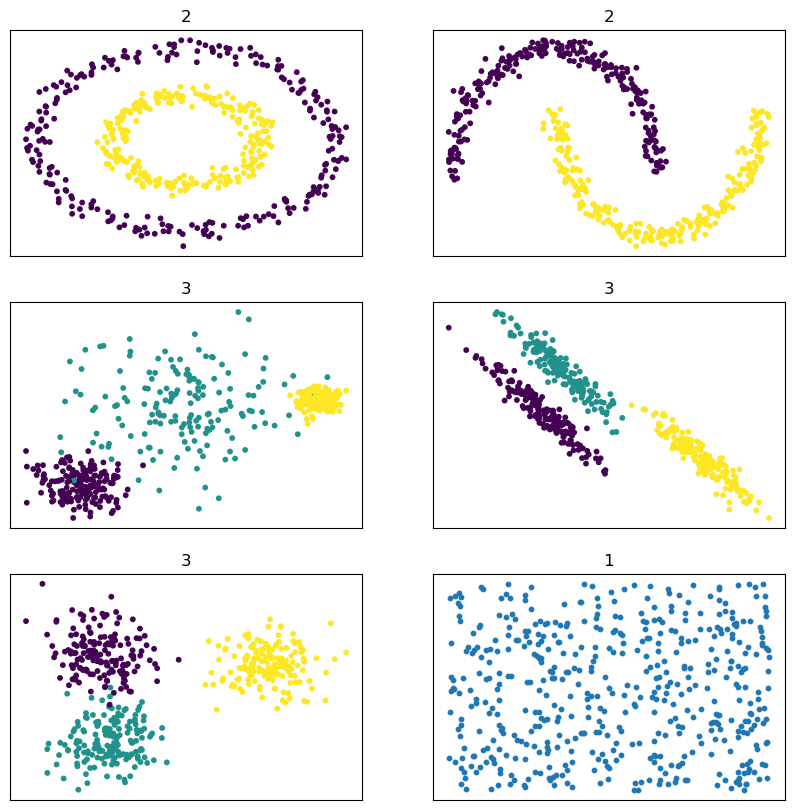

In [3]:
# Plot the generated data
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes = axes.flatten()
for ax, dataset in zip(axes, datasets_):
    X, y = dataset
    ax.scatter(X[:, 0], X[:, 1], s=10, c=y, cmap="viridis")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title("{}".format(len(np.unique(y))))

/Users/michaelthomas/Desktop/Semester 4/math466/project/pycvxcluster-main/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/michaelthomas/Desktop/Semester 4/math466/project/pycvxcluster-main/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


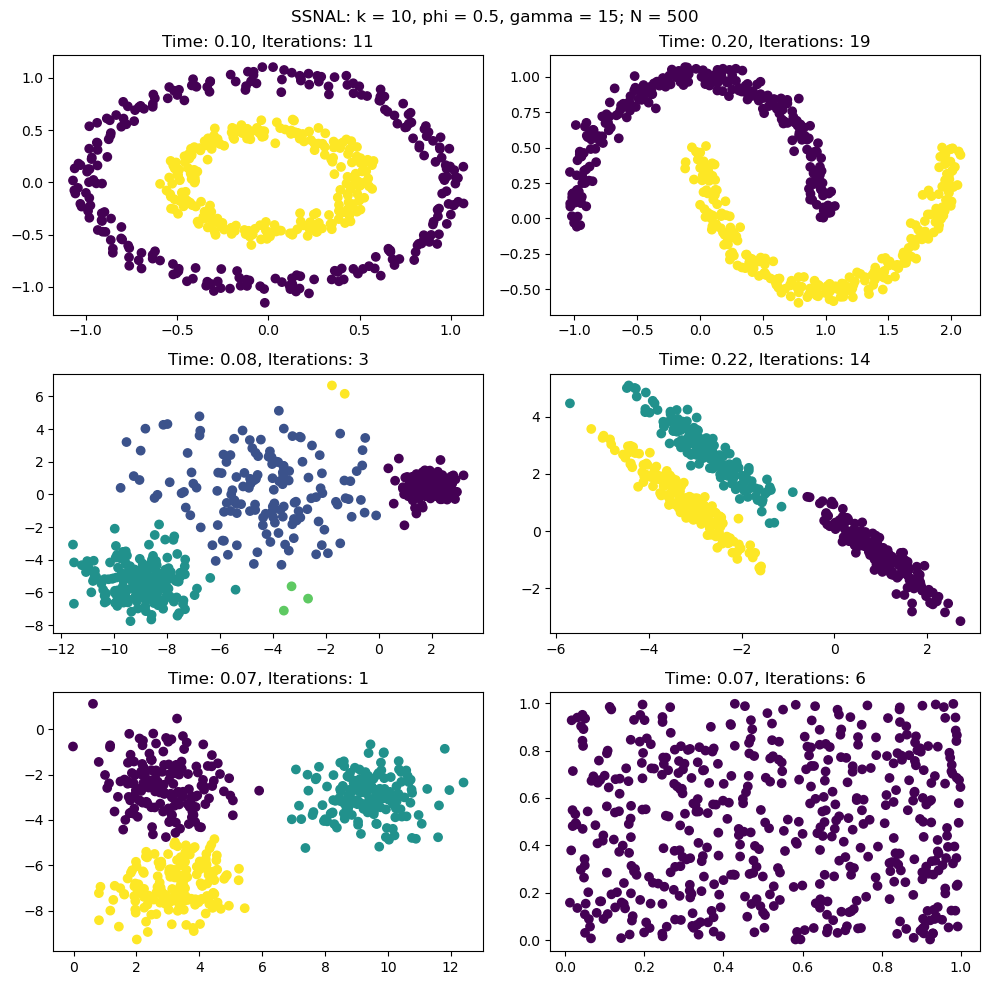

In [4]:
ssnal = pycvxcluster.pycvxcluster.SSNAL(k=10, phi=0.5, gamma=15)
times = np.zeros(len(datasets_))
iterations = np.zeros(len(datasets_))
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
for i, data in enumerate(datasets_):
    ssnal.fit(data[0])
    times[i] = ssnal.total_time_
    iterations[i] = ssnal.iter_
    axes[i // 2, i % 2].scatter(data[0][:, 0], data[0][:, 1], c=ssnal.labels_)
    axes[i // 2, i % 2].set_title(
        f"Time: {times[i]:.2f}, Iterations: {iterations[i]:.0f}"
    )
fig.suptitle(
    f"SSNAL: k = {ssnal.k}, phi = {ssnal.phi}, gamma = {ssnal.gamma}; N = {n_samples}"
)
plt.tight_layout()
plt.show()

Running for 100 samples----------------------------------
----------------------------------
Running for 500 samples----------------------------------
----------------------------------
Running for 1000 samples----------------------------------
----------------------------------
Running for 2000 samples----------------------------------
----------------------------------
Running for 5000 samples----------------------------------
----------------------------------
Running for 10000 samples----------------------------------
----------------------------------
Running for 20000 samples----------------------------------
----------------------------------
Running for 30000 samples----------------------------------
----------------------------------
Running for 40000 samples----------------------------------
----------------------------------
Running for 50000 samples----------------------------------
----------------------------------


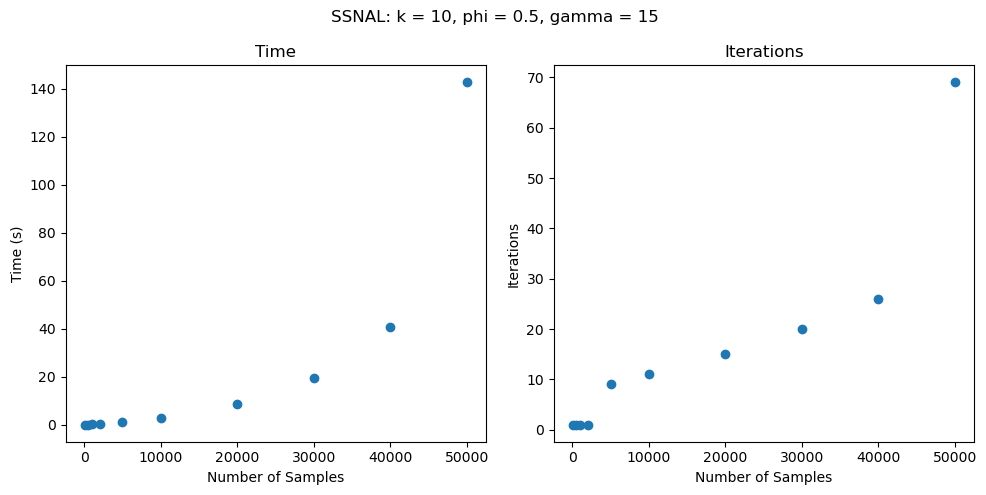

In [5]:
sizes = [100, 500, 1000, 2000, 5000, 10000, 20000, 30000, 40000, 50000]
times = np.zeros(len(sizes))
iterations = np.zeros(len(sizes))
n_fits = 3
for j, n in enumerate(sizes):
    print(f"Running for {n} samples----------------------------------")
    for i in range(n_fits):
        X, y = datasets.make_blobs(n_samples=n, centers=5, random_state=random_state)
        ssnal = pycvxcluster.pycvxcluster.SSNAL(k=10, phi=0.5, gamma=15)
        labels = ssnal.fit_predict(X)
        times[j] += ssnal.total_time_
        iterations[j] += ssnal.iter_
    times[j] /= n_fits
    iterations[j] /= n_fits
    print("----------------------------------")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(sizes, times)
axes[0].set_title("Time")
axes[0].set_xlabel("Number of Samples")
axes[0].set_ylabel("Time (s)")
axes[1].scatter(sizes, iterations)
axes[1].set_title("Iterations")
axes[1].set_xlabel("Number of Samples")
axes[1].set_ylabel("Iterations")
fig.suptitle(f"SSNAL: k = {ssnal.k}, phi = {ssnal.phi}, gamma = {ssnal.gamma}")
plt.tight_layout()
plt.show()

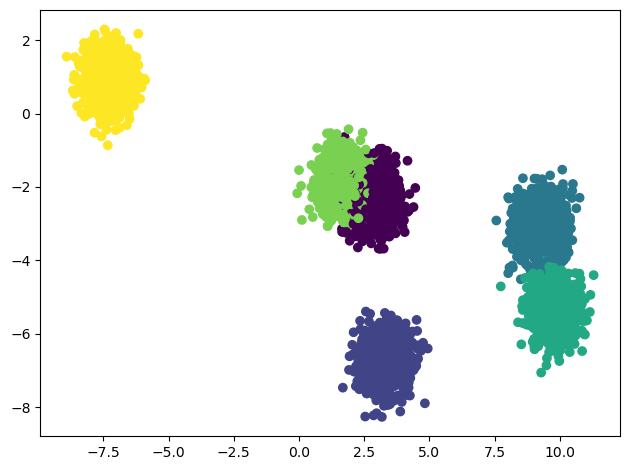

In [6]:
# generate 6 blobs and plot the true clusters
n_samples = 5000
blobs = datasets.make_blobs(
    n_samples=n_samples, random_state=seed, centers=6, cluster_std=0.5
)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(blobs[0][:, 0], blobs[0][:, 1], c=blobs[1])
plt.tight_layout()
plt.show()

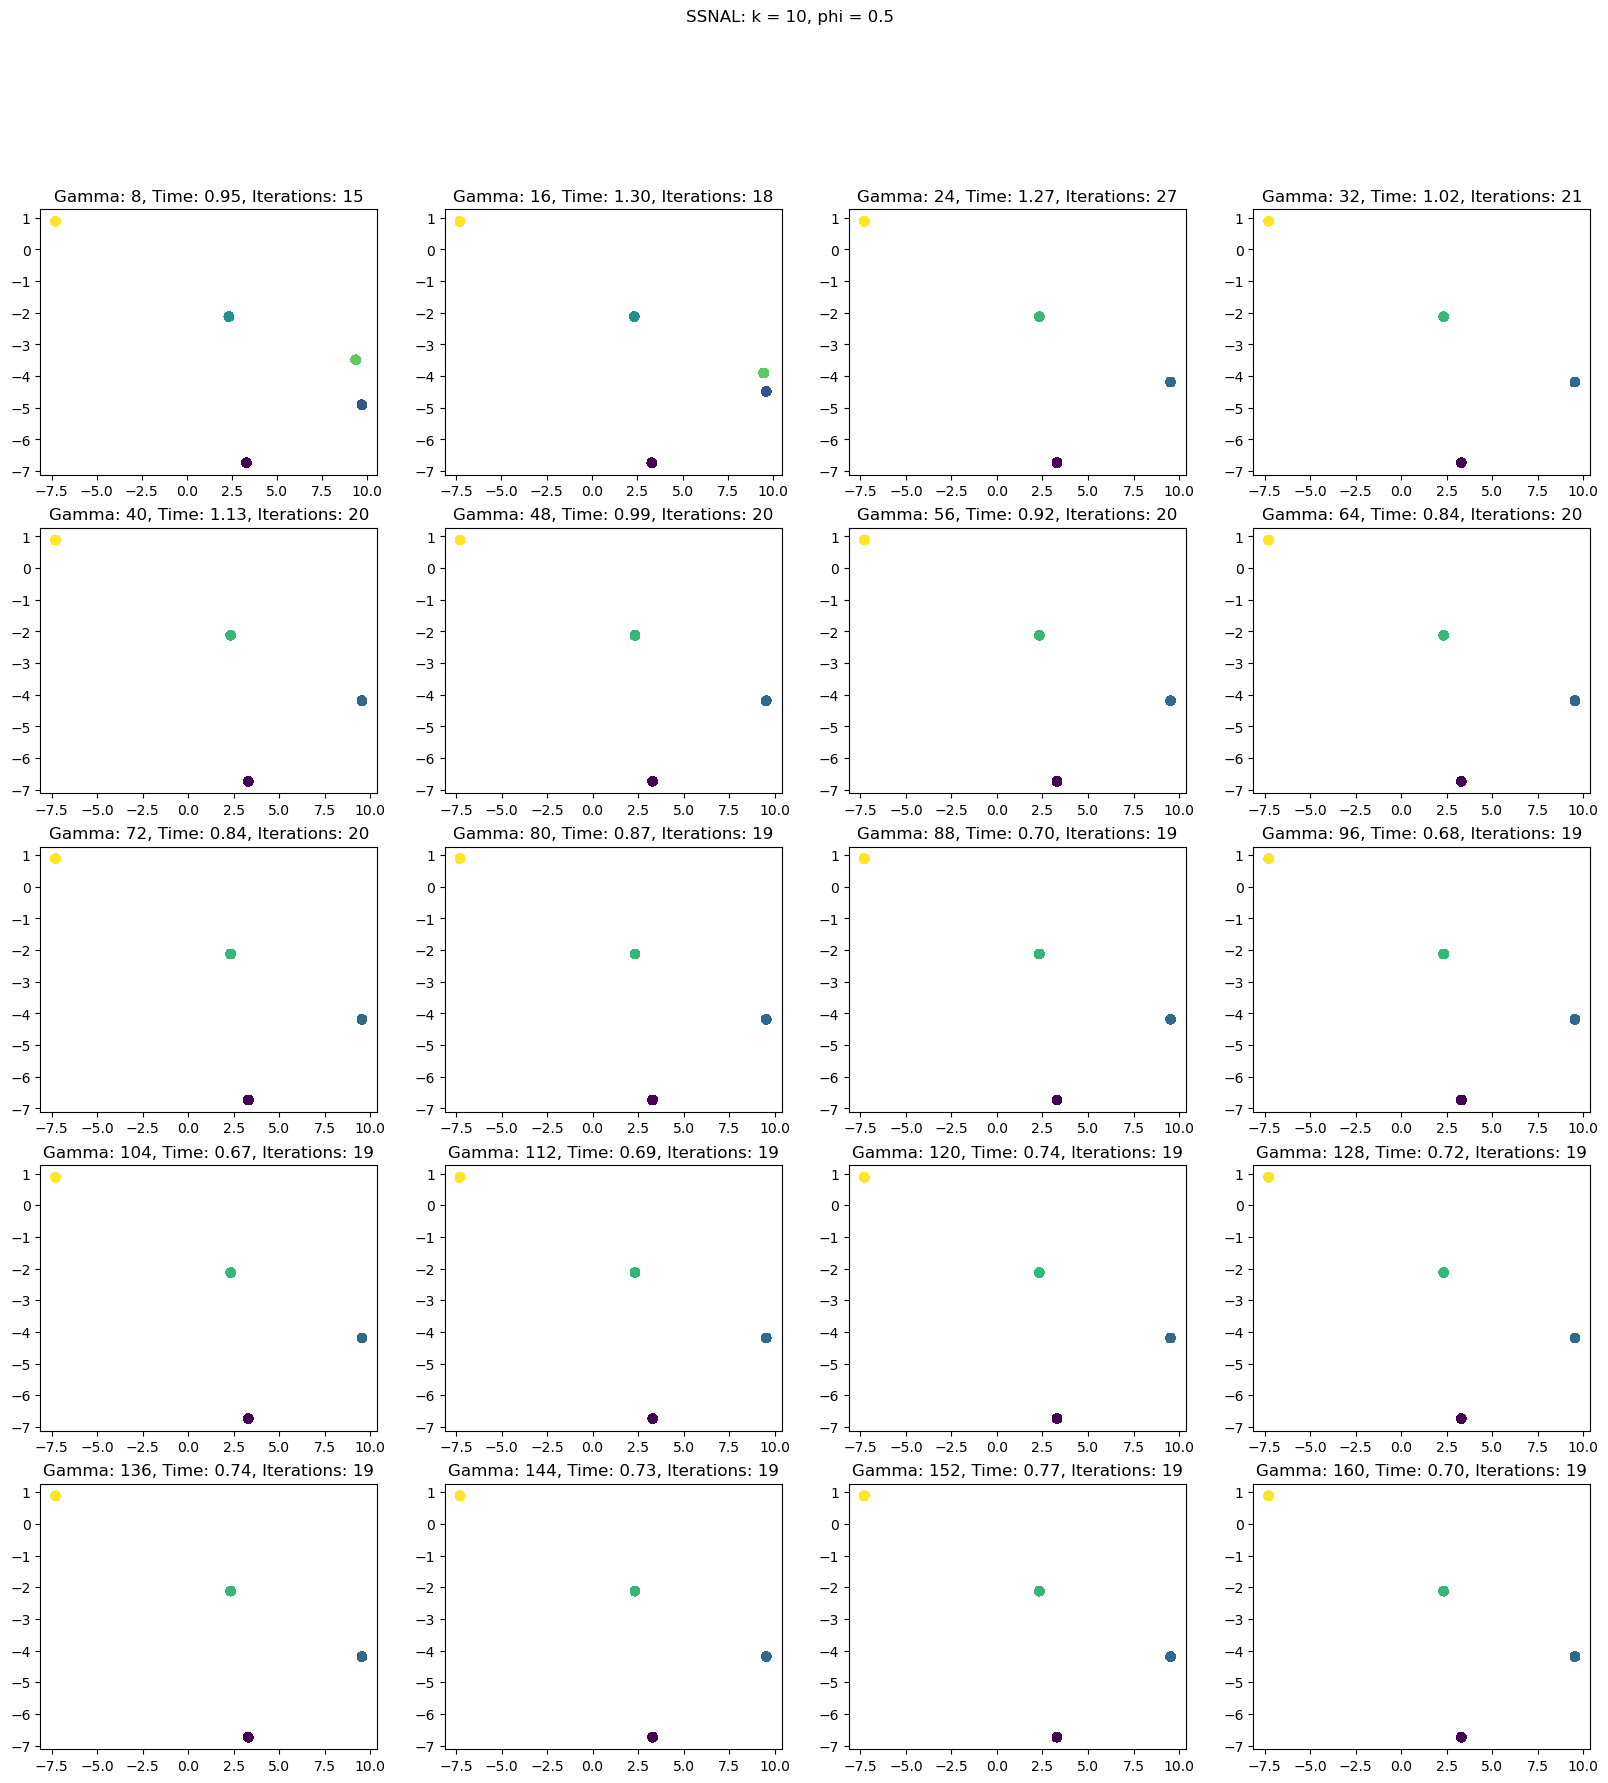

In [7]:
# run ssnal on the blobs with varying gamma from 1 to 20 and plot the results
fig, axes = plt.subplots(5, 4, figsize=(10, 10))
fig.set_size_inches(20, 20)
centers = np.zeros((20, n_samples, 2))
for i in range(20):
    ssnal = pycvxcluster.pycvxcluster.SSNAL(k=10, phi=0.5, gamma=(i + 1) * 8)
    labels = ssnal.fit_predict(blobs[0], save_centers=True)
    centers[i, :, :] = ssnal.centers_.T
    axes[i // 4, i % 4].scatter(ssnal.centers_[0, :], ssnal.centers_[1, :], c=labels)
    axes[i // 4, i % 4].set_title(
        f"Gamma: {(i+1)*8}, Time: {ssnal.total_time_:.2f}, Iterations: {ssnal.iter_:.0f}"
    )
fig.suptitle(f"SSNAL: k = {ssnal.k}, phi = {ssnal.phi}")
plt.show()

5000
Computing weight matrix...
Weight matrix computed in 0.21908950002398342 seconds.
Starting ADMM...
ADMM finished in 153.50309791695327 seconds.
Termination status: Maximum number of iterations reached, iterations: 19999
Clustering completed in 153.72218741697725 seconds.
5000
Computing weight matrix...
Weight matrix computed in 0.21855333296116441 seconds.
Starting ADMM...
ADMM finished in 140.16304662497714 seconds.
Termination status: Maximum number of iterations reached, iterations: 19999
Clustering completed in 140.3815999579383 seconds.
5000
Computing weight matrix...
Weight matrix computed in 0.22050658299122006 seconds.
Starting ADMM...
ADMM finished in 14.682762166950852 seconds.
Termination status: Successful convergence, iterations: 2520
Clustering completed in 14.903268749942072 seconds.
5000
Computing weight matrix...
Weight matrix computed in 0.22041366598568857 seconds.
Starting ADMM...
ADMM finished in 8.041586708044633 seconds.
Termination status: Successful conver

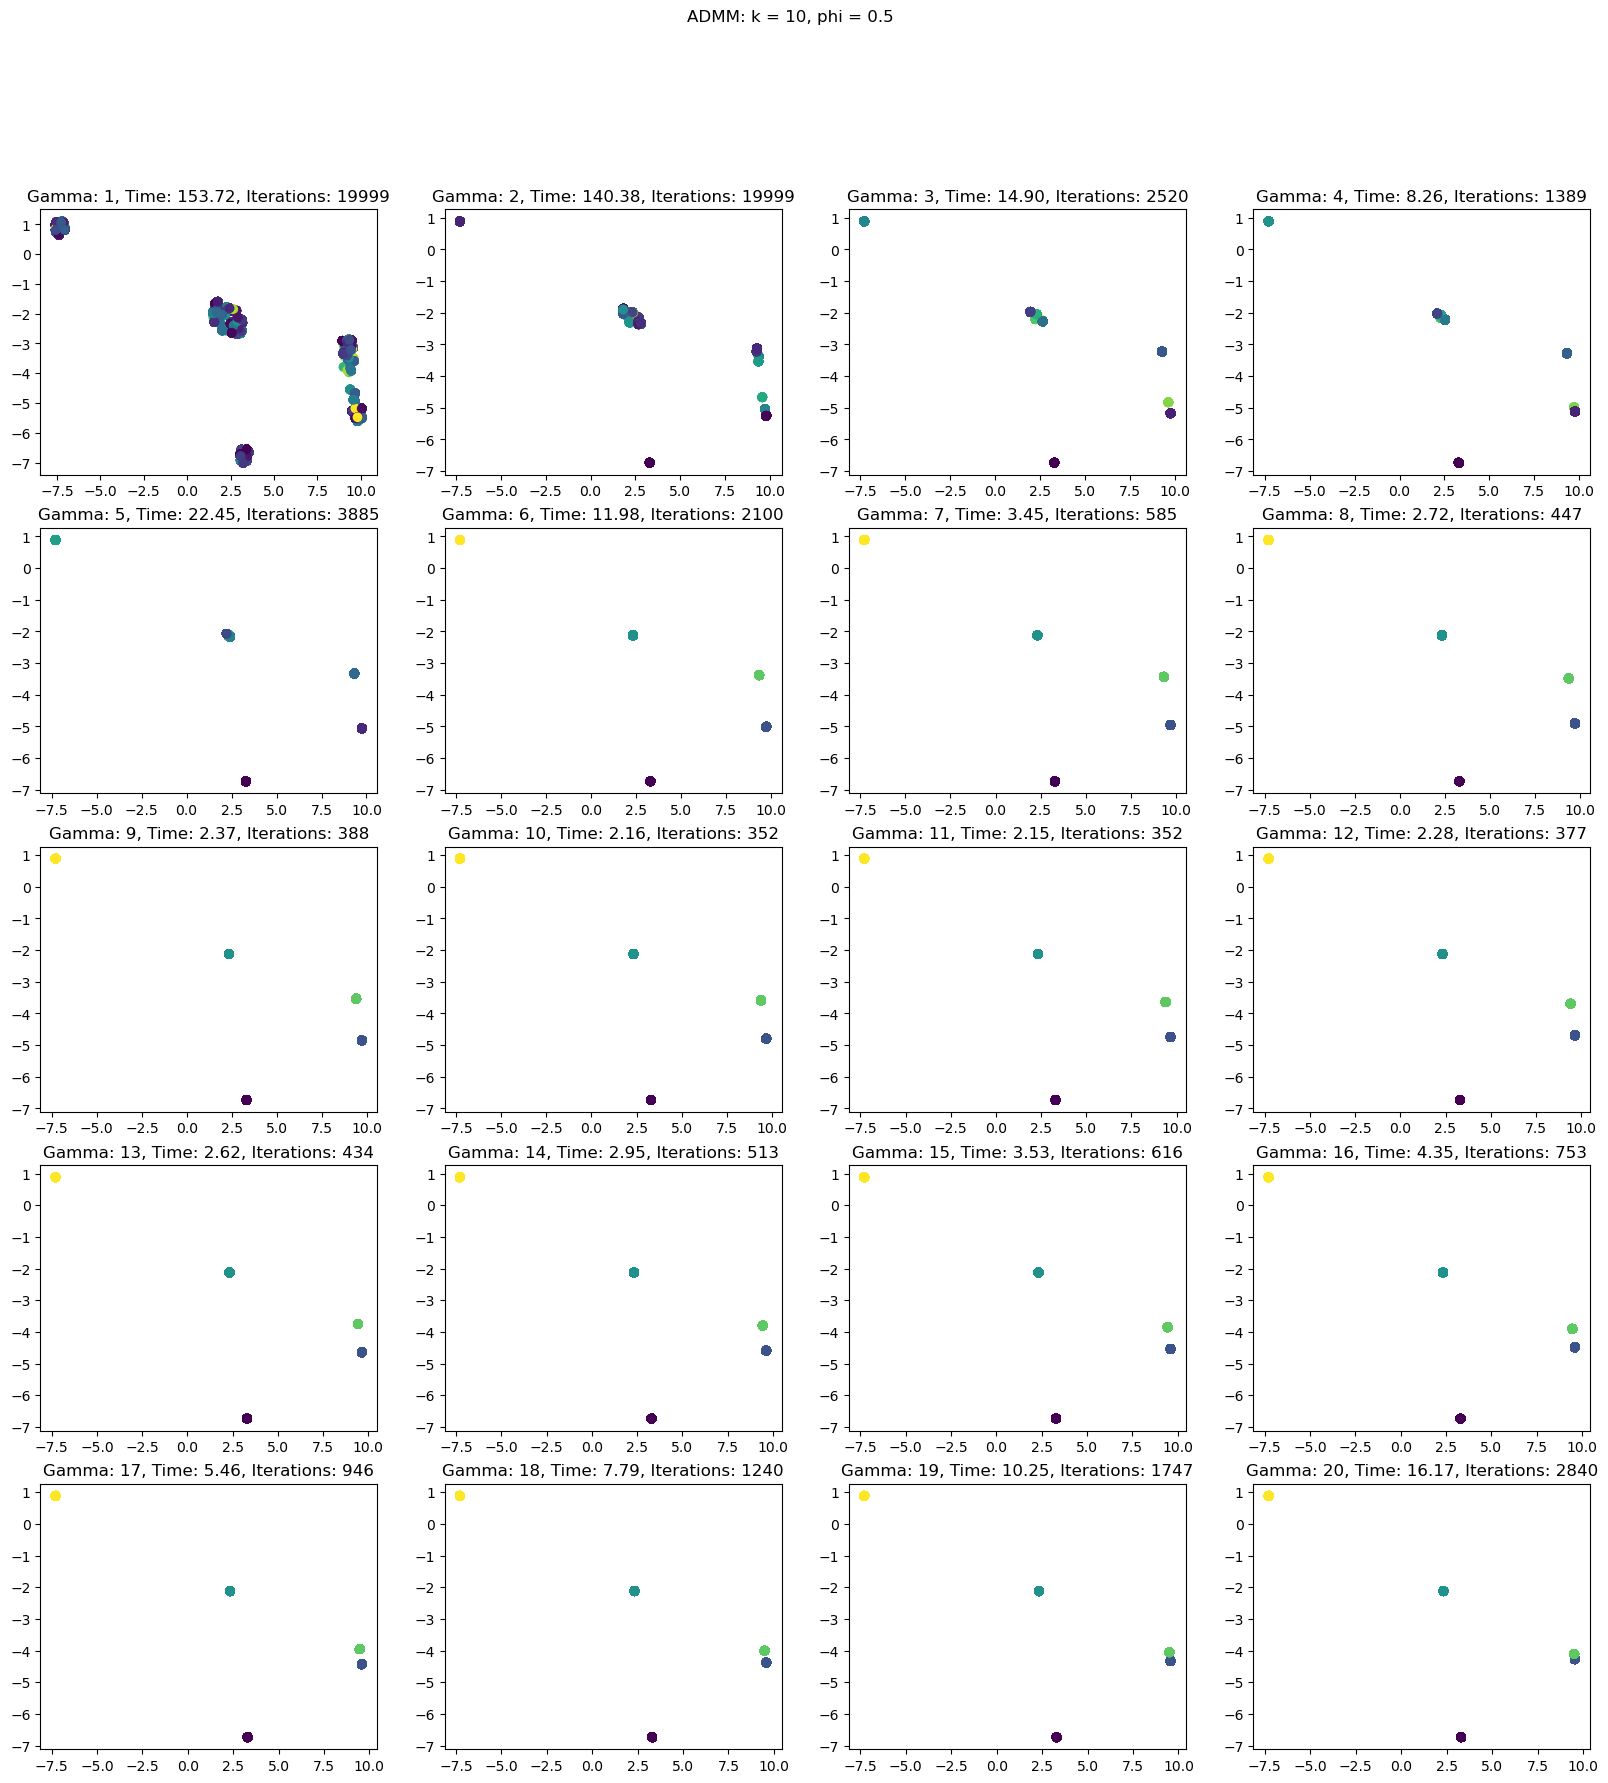

In [ ]:
# run ADMM on the blobs with varying gamma from 1 to 20 and plot the results
fig, axes = plt.subplots(5, 4, figsize=(10, 10))
fig.set_size_inches(20, 20)
centers = np.zeros((20, n_samples, 2))
for i in range(20):
    admm = pycvxcluster.pycvxcluster.ADMM(k=10, phi=0.5, gamma=(i + 1))
    labels = admm.fit_predict(blobs[0], save_centers=True)
    centers[i, :, :] = admm.centers_.T
    axes[i // 4, i % 4].scatter(admm.centers_[0, :], admm.centers_[1, :], c=labels)
    axes[i // 4, i % 4].set_title(
        f"Gamma: {i+1}, Time: {admm.total_time_:.2f}, Iterations: {admm.iter_:.0f}"
    )
fig.suptitle(f"ADMM: k = {admm.k}, phi = {admm.phi}")
plt.show()

In [ ]:
# plot both ADMM and SSNAL running time vs number of samples
sizes = [100, 500, 1000, 2000, 5000, 10000, 20000]
times_admm = np.zeros(len(sizes))
times_ssnal = np.zeros(len(sizes))
iterations_admm = np.zeros(len(sizes))
iterations_ssnal = np.zeros(len(sizes))
n_fits = 3
for j, n in enumerate(sizes):
    print(f"Running for {n} samples----------------------------------")
    for i in range(n_fits):
        X, y = datasets.make_blobs(n_samples=n, centers=5, random_state=random_state)
        admm = pycvxcluster.pycvxcluster.ADMM(
            k=10, phi=0.5, gamma=15, verbose=0, maxiter=50000
        )
        labels = admm.fit_predict(X)
        times_admm[j] += admm.total_time_
        iterations_admm[j] += admm.iter_
        ssnal = pycvxcluster.pycvxcluster.SSNAL(k=10, phi=0.5, gamma=15, verbose=0)
        labels = ssnal.fit_predict(X)
        times_ssnal[j] += ssnal.total_time_
        iterations_ssnal[j] += ssnal.iter_
    times_admm[j] /= n_fits
    iterations_admm[j] /= n_fits
    times_ssnal[j] /= n_fits
    iterations_ssnal[j] /= n_fits
    print("----------------------------------")

In [ ]:
iterations_admm

array([ 22.,  27.,  31.,  55., 209., 251., 515.])

In [ ]:
iterations_ssnal

array([ 6.,  8.,  9., 10., 13., 14., 18.])

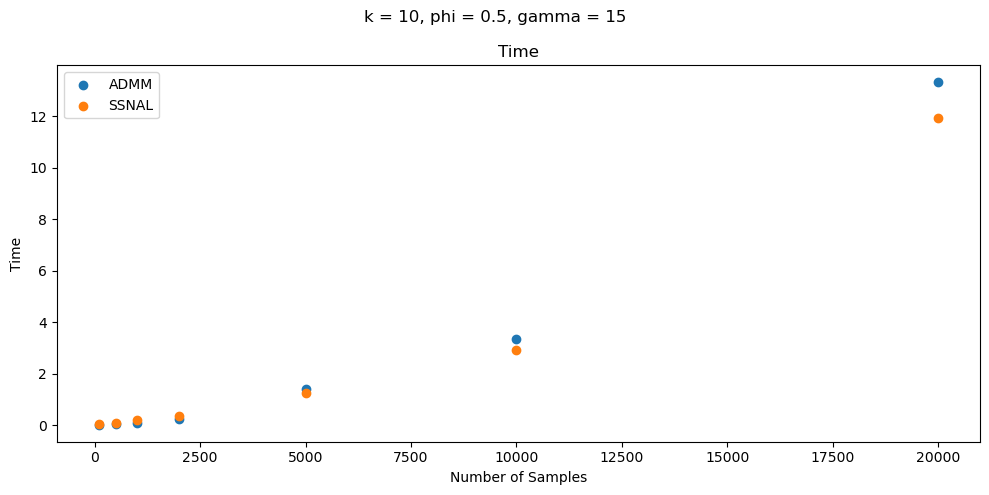

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(sizes, times_admm, label="ADMM")
ax.scatter(sizes, times_ssnal, label="SSNAL")
ax.set_title("Time")
ax.set_xlabel("Number of Samples")
ax.set_ylabel("Time")
ax.legend()
fig.suptitle(f"k = {admm.k}, phi = {admm.phi}, gamma = {admm.gamma}")
plt.tight_layout()
plt.show()

Running for 2 dimensions----------------------------------


/Users/dxli2/Downloads/ConvexClustering/pycvxcluster/./src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


1
1
1
----------------------------------
Running for 4 dimensions----------------------------------


/Users/dxli2/Downloads/ConvexClustering/pycvxcluster/./src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in double_scalars
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


1
1
1
----------------------------------
Running for 6 dimensions----------------------------------
1
1
1
----------------------------------
Running for 8 dimensions----------------------------------
1
1
1
----------------------------------
Running for 10 dimensions----------------------------------
1
1
1
----------------------------------
Running for 12 dimensions----------------------------------
1
1
1
----------------------------------
Running for 14 dimensions----------------------------------
1
1
1
----------------------------------
Running for 16 dimensions----------------------------------
1
1
1
----------------------------------
Running for 18 dimensions----------------------------------
1
1
1
----------------------------------
Running for 20 dimensions----------------------------------
1
1
1
----------------------------------
Running for 22 dimensions----------------------------------
1
1
1
----------------------------------
Running for 24 dimensions---------------------------

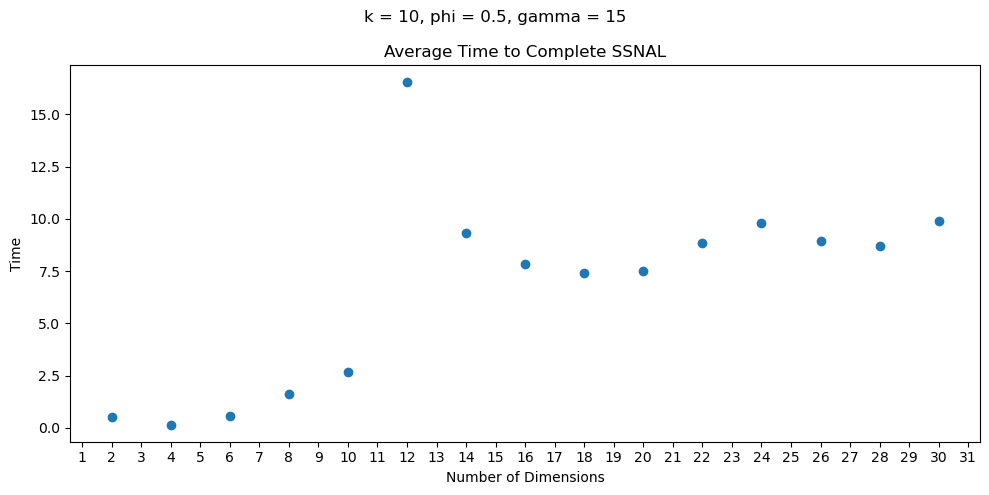

In [ ]:
# plot SSNAL varying dimensionality
dims = [x for x in range(2, 31, 2)]
times_ssnal = np.zeros(len(dims))
iterations_ssnal = np.zeros(len(dims))
n_fits = 3
n_samples = 2000
random_state = 12
for j, n in enumerate(dims):
    print(f"Running for {n} dimensions----------------------------------")
    for i in range(n_fits):
        X, y = datasets.make_blobs(n_samples=n_samples, centers=4, n_features=n, random_state=random_state)
        ssnal = pycvxcluster.pycvxcluster.SSNAL(k=10, phi=0.5, gamma=15, verbose=0)
        labels = ssnal.fit_predict(X)
        times_ssnal[j] += ssnal.ssnal_runtime_
        iterations_ssnal[j] += ssnal.iter_
        print(ssnal.termination_)
    times_ssnal[j] /= n_fits
    iterations_ssnal[j] /= n_fits
    print("----------------------------------")

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(dims, times_ssnal)
ax.set_title("Average Time to Complete SSNAL")
ax.set_xlabel("Number of Dimensions")
ax.set_ylabel("Time")
loc = plticker.MultipleLocator(base=1.0) 
ax.xaxis.set_major_locator(loc)
fig.suptitle(f"k = {ssnal.k}, phi = {ssnal.phi}, gamma = {ssnal.gamma}")
plt.tight_layout()
plt.show()

Running for 3 dimensions----------------------------------


/Users/dxli2/Downloads/ConvexClustering/pycvxcluster/./src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in double_scalars
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


1
1
1
----------------------------------
Running for 10 dimensions----------------------------------
1
1
1
----------------------------------
Running for 20 dimensions----------------------------------
1
1
1
----------------------------------
Running for 50 dimensions----------------------------------
1
1
1
----------------------------------
Running for 100 dimensions----------------------------------
1
1
1
----------------------------------
Running for 200 dimensions----------------------------------
1
1
1
----------------------------------
Running for 500 dimensions----------------------------------
1
1
1
----------------------------------
Running for 1000 dimensions----------------------------------
ADMM converged in 1 iterations.
1
ADMM converged in 1 iterations.
1
ADMM converged in 1 iterations.
1
----------------------------------


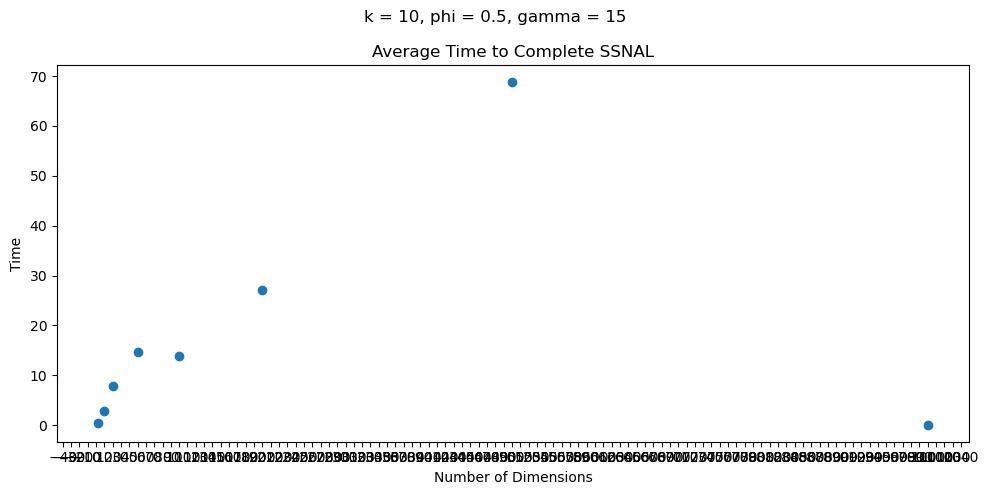

In [ ]:
# plot SSNAL varying dimensionality
dims = [3, 10, 20, 50, 100, 200, 500, 1000]
times_ssnal = np.zeros(len(dims))
iterations_ssnal = np.zeros(len(dims))
n_fits = 3
n_samples = 2000
random_state = 12
for j, n in enumerate(dims):
    print(f"Running for {n} dimensions----------------------------------")
    for i in range(n_fits):
        X, y = datasets.make_blobs(n_samples=n_samples, centers=4, n_features=n, random_state=random_state)
        ssnal = pycvxcluster.pycvxcluster.SSNAL(k=10, phi=0.5, gamma=15, verbose=0)
        labels = ssnal.fit_predict(X)
        times_ssnal[j] += ssnal.ssnal_runtime_
        iterations_ssnal[j] += ssnal.iter_
        print(ssnal.termination_)
    times_ssnal[j] /= n_fits
    iterations_ssnal[j] /= n_fits
    print("----------------------------------")
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(dims, times_ssnal)
ax.set_title("Average Time to Complete SSNAL")
ax.set_xlabel("Number of Dimensions")
ax.set_ylabel("Time")
loc = plticker.MultipleLocator(base=10) 
ax.xaxis.set_major_locator(loc)
fig.suptitle(f"k = {ssnal.k}, phi = {ssnal.phi}, gamma = {ssnal.gamma}")
plt.tight_layout()
plt.show()


In [ ]:
# Compare SSNAL with admm iter and without as n_samples increases
from pycvxcluster.algos.compute_weights import compute_weights
random_state = 12
sizes = [100, 500, 1000, 2000, 5000, 10000, 20000]
times_ssnal_no_admm = np.zeros(len(sizes))
times_ssnal_admm = np.zeros(len(sizes))
iterations_ssnal_no_admm = np.zeros(len(sizes))
iterations_ssnal_admm = np.zeros(len(sizes))
n_fits = 3

for j, n in enumerate(sizes):
    print(f"Running for {n} samples----------------------------------")
    for i in range(n_fits):
        X, y = datasets.make_blobs(n_samples=n, centers=5, random_state=random_state)
        ssnal = pycvxcluster.pycvxcluster.SSNAL(k=10, phi=0.5, gamma=15, verbose=0)
        wv, nam, *_ = compute_weights(X.T, ssnal.k, ssnal.phi, ssnal.gamma)
        ssnal.weight_vec_ = wv
        ssnal.node_arc_matrix_ = nam
        ssnal.admm_iter = 0
        labels = ssnal.fit_predict(X, recalculate_weights=False)
        times_ssnal_no_admm[j] += ssnal.ssnal_runtime_
        iterations_ssnal_no_admm[j] += ssnal.iter_

        ssnal.admm_iter = 50
        labels = ssnal.fit_predict(X, recalculate_weights=False)
        times_ssnal_admm[j] += ssnal.total_time_
        iterations_ssnal_admm[j] += ssnal.iter_
    times_ssnal_no_admm[j] /= n_fits
    iterations_ssnal_no_admm[j] /= n_fits
    times_ssnal_admm[j] /= n_fits
    iterations_ssnal_admm[j] /= n_fits
    print("----------------------------------")


Running for 100 samples----------------------------------
Computing weights...
Computing weight matrix...
Weight matrix computed in 0.005476667080074549 seconds.
Weights computed in 0.006186791928485036 seconds.


/Users/dxli2/Downloads/ConvexClustering/pycvxcluster/./src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in double_scalars
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/dxli2/Downloads/ConvexClustering/pycvxcluster/./src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Computing weights...
Computing weight matrix...
Weight matrix computed in 0.005523999920114875 seconds.
Weights computed in 0.006011916091665626 seconds.
Computing weights...
Computing weight matrix...
Weight matrix computed in 0.005026292055845261 seconds.
Weights computed in 0.005526707973331213 seconds.
----------------------------------
Running for 500 samples----------------------------------
Computing weights...
Computing weight matrix...
Weight matrix computed in 0.021863665897399187 seconds.
Weights computed in 0.023151207948103547 seconds.
Computing weights...
Computing weight matrix...
Weight matrix computed in 0.021006416995078325 seconds.
Weights computed in 0.02221424994058907 seconds.
Computing weights...
Computing weight matrix...
Weight matrix computed in 0.021299292100593448 seconds.
Weights computed in 0.022380458191037178 seconds.
----------------------------------
Running for 1000 samples----------------------------------
Computing weights...
Computing weight matrix

/Users/dxli2/Downloads/ConvexClustering/pycvxcluster/./src/pycvxcluster/algos/ssnal.py:438: RuntimeWarning: invalid value encountered in double_scalars
  dualinf_ratio = dualinf_hist[itersub] / dualinf_hist[itersub - 1]


Computing weights...
Computing weight matrix...
Weight matrix computed in 0.04311145795509219 seconds.
Weights computed in 0.045057165902107954 seconds.
Computing weights...
Computing weight matrix...
Weight matrix computed in 0.04346383293159306 seconds.
Weights computed in 0.04577495786361396 seconds.
----------------------------------
Running for 2000 samples----------------------------------
Computing weights...
Computing weight matrix...
Weight matrix computed in 0.08815183280967176 seconds.
Weights computed in 0.09217820805497468 seconds.
Computing weights...
Computing weight matrix...
Weight matrix computed in 0.08789941715076566 seconds.
Weights computed in 0.09157916693948209 seconds.
Computing weights...
Computing weight matrix...
Weight matrix computed in 0.08692770800553262 seconds.
Weights computed in 0.09074312495067716 seconds.
----------------------------------
Running for 5000 samples----------------------------------
Computing weights...
Computing weight matrix...
Wei

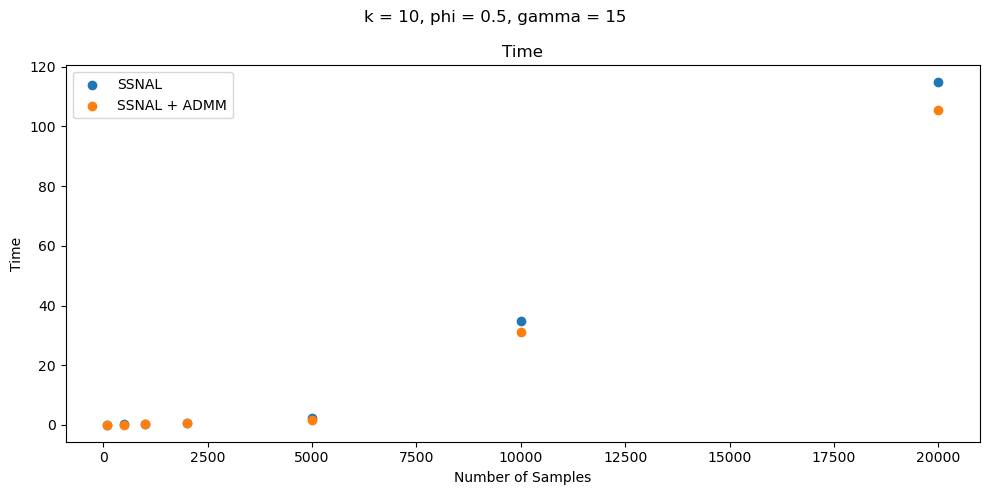

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(sizes, times_ssnal_no_admm, label="SSNAL")
ax.scatter(sizes, times_ssnal_admm, label="SSNAL + ADMM")
ax.set_title("Time")
ax.set_xlabel("Number of Samples")
ax.set_ylabel("Time")
ax.legend()
fig.suptitle(f"k = {ssnal.k}, phi = {ssnal.phi}, gamma = {ssnal.gamma}")
plt.tight_layout()
plt.show()

Running for 2 phi----------------------------------
1
1
1
----------------------------------
Running for 4 phi----------------------------------
1
1
1
----------------------------------
Running for 8 phi----------------------------------
1
1
1
----------------------------------
Running for 16 phi----------------------------------
1
1
1
----------------------------------
Running for 32 phi----------------------------------
1
1
1
----------------------------------
Running for 64 phi----------------------------------
1
1
1
----------------------------------
Running for 128 phi----------------------------------
1
1
1
----------------------------------
Running for 256 phi----------------------------------
1
1
1
----------------------------------
Running for 512 phi----------------------------------
1
1
1
----------------------------------
Running for 1024 phi----------------------------------
1
1
1
----------------------------------
Running for 2048 phi----------------------------------
1
1

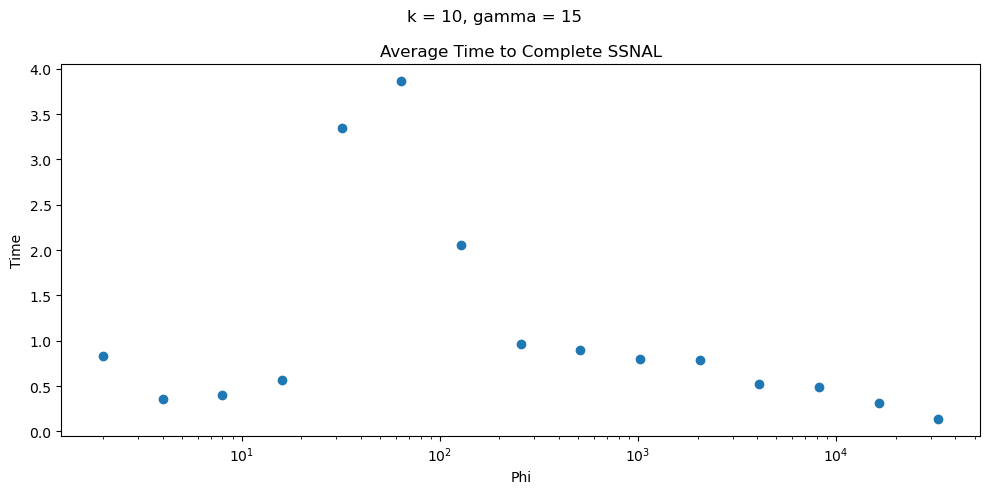

In [ ]:
#plot time to complete SSNAL vs phi
phis = [2**x for x in range(1, 16)]
times_ssnal = np.zeros(len(phis))
iterations_ssnal = np.zeros(len(phis))
n_fits = 3
n_samples = 2000
random_state = 12
for j, n in enumerate(phis):
    print(f"Running for {n} phi----------------------------------")
    for i in range(n_fits):
        X, y = datasets.make_blobs(n_samples=n_samples, centers=4, n_features=2, random_state=random_state)
        ssnal = pycvxcluster.pycvxcluster.SSNAL(k=10, phi=n, gamma=15, verbose=0, admm_iter=100)
        labels = ssnal.fit_predict(X)
        times_ssnal[j] += ssnal.ssnal_runtime_
        iterations_ssnal[j] += ssnal.iter_
        print(ssnal.termination_)
    times_ssnal[j] /= n_fits
    iterations_ssnal[j] /= n_fits
    print("----------------------------------")

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(phis, times_ssnal)
ax.set_title("Average Time to Complete SSNAL")
ax.set_xlabel("Phi")
ax.set_ylabel("Time")
ax.set_xscale('log')
fig.suptitle(f"k = {ssnal.k}, gamma = {ssnal.gamma}")
plt.tight_layout()
plt.show()

In [9]:
from pycvxcluster.algos.compute_weights import compute_weight_matrix
from sklearn.preprocessing import StandardScaler
X = datasets.make_blobs(n_samples=1000, centers=5, n_features=2, random_state=12)[0]
X = StandardScaler().fit_transform(X)
weight_matrix, _ = compute_weight_matrix(X.T, 10, 0.5, 15)

Computing weight matrix...
Weight matrix computed in 0.0690099997445941 seconds.


In [18]:
weight_matrix[0, 1] = 1
weight_matrix[[0], :]

<1x1000 sparse array of type '<class 'numpy.float64'>'
	with 13 stored elements in Compressed Sparse Row format>

In [ ]:
ssnal = pycvxcluster.pycvxcluster.SSNAL(k=10, phi=0.5, gamma=1, verbose=0, admm_iter=100)
labels1 = ssnal.fit_predict(X, weight_matrix=.8*weight_matrix, save_centers=True)
centers = ssnal.centers_

/Users/dxli2/Downloads/ConvexClustering/pycvxcluster/./src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/dxli2/Downloads/ConvexClustering/pycvxcluster/./src/pycvxcluster/algos/ssnal.py:339: RuntimeWarning: invalid value encountered in double_scalars
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


In [ ]:
centers

array([[ 1.18753463, -0.79168981, -0.79168982, ...,  1.18753463,
        -0.79168977, -0.79168982],
       [-1.12627227,  0.75084828,  0.75084829, ..., -1.12627227,
         0.75084821,  0.75084829]])

In [ ]:
ssnal = pycvxcluster.pycvxcluster.SSNAL(k=10, phi=0.5, gamma=.8, verbose=0, admm_iter=100)
labels2 = ssnal.fit_predict(X, weight_matrix=weight_matrix, save_centers=True)
centers2 = ssnal.centers_

In [ ]:
centers2

array([[ 1.18753463, -0.79168981, -0.79168982, ...,  1.18753463,
        -0.79168977, -0.79168982],
       [-1.12627227,  0.75084828,  0.75084829, ..., -1.12627227,
         0.75084821,  0.75084829]])

In [ ]:
(labels1 == labels2).all()

True

In [ ]:
np.max(centers-centers2)

0.0

In [ ]:
ssnal = pycvxcluster.pycvxcluster.SSNAL(k=10, phi=0.5, gamma=1, verbose=0, admm_iter=100)
labels3 = ssnal.fit_predict(X, weight_matrix=.8*weight_matrix, save_centers=True)
centers3 = ssnal.centers_

In [ ]:
np.max(centers-centers3)

0.0